In [1]:
import os
if "models" not in os.listdir("."):
    os.chdir("..")

In [2]:
%load_ext autoreload
%autoreload 2
import penzai
from penzai import pz
pz.ts.register_as_default()
pz.ts.register_autovisualize_magic()
pz.enable_interactive_context()

In [3]:
from micrlhf.llama import LlamaTransformer
llama = LlamaTransformer.from_pretrained("models/gemma-2b-it.gguf",
                                         from_type="gemma",
                                         load_eager=True
                                         )

In [4]:
!mkdir -p data
import pandas as pd
df_adv = pd.read_csv("data/adv.csv")
format_prompt = """<start_of_turn>user\n
{}\n
<start_of_turn>model\n
{}"""
# offset = 1
# df_do = df.apply(lambda x: format_response.format(x['goal'], x['target']), axis=1)
# prompts_harmful = df.apply(lambda x: format_prompt.format(x['goal'], "")[:-offset], axis=1).to_list()[:100]
prompts_harmful = df_adv.apply(lambda x: format_prompt.format(x['goal'], ""), axis=1).to_list()[:100]
dataset_jail = pd.read_csv("data/jail.csv").apply(lambda x: x["Goal"], axis=1).to_list()
prompts_jail = [format_prompt.format(x, "") for x in dataset_jail]
import datasets
# https://colab.research.google.com/drive/1a-aQvKC9avdZpdyBn4jgRQFObTPy1JZw
hf_path = 'tatsu-lab/alpaca'
dataset = datasets.load_dataset(hf_path)
# filter for instructions that do not have inputs
prompts_harmless = []
for i in range(len(dataset['train'])):
    if len(prompts_harmless) >= len(prompts_harmful):
        break
    if dataset['train'][i]['input'].strip() == '':
        # prompts_harmless.append(format_prompt.format(dataset['train'][i]['instruction'], "")[:-offset])
        prompts_harmless.append(format_prompt.format(dataset['train'][i]['instruction'], ""))

# ds = datasets.load_dataset("MBZUAI/LaMini-instruction", split="train", streaming=True)
# prompts_harmless = []
# for _, text in zip(range(100), ds):
#     prompts_harmless.append(format_prompt.format(text["instruction"], ""))

# ds = datasets.load_dataset("nev/openhermes-2.5-phi-format-text", split="train", streaming=True)
# prompts_harmless = []
# for _, text in zip(range(100), ds):
#     text = text["text"]
#     text = "".join(text.partition("<|assistant|>\n")[:2])
#     prompts_harmless.append(text)

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [5]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("NousResearch/gemma-2b-it-tokenizer")
tokenizer.padding_side = "right"

In [6]:
from micrlhf.sampling import sample, trange, jnp, load_tokenizer, jit_wrapper
import jax

tokens = tokenizer.batch_encode_plus(prompts_harmful + prompts_harmless,
                                     return_tensors="np",
                                     padding="max_length",
                                     truncation=True,
                                     max_length=128,
                                     return_attention_mask=True)
token_array = jnp.asarray(tokens["input_ids"])
token_array = jax.device_put(token_array, jax.sharding.NamedSharding(llama.mesh, jax.sharding.PartitionSpec("dp", "sp")))
token_array = pz.nx.wrap(token_array, "batch", "seq").untag("batch").tag("batch")
inputs = llama.inputs.from_basic_segments(token_array)

In [7]:
from micrlhf.llama import LlamaBlock
from micrlhf.flash import flashify
from micrlhf.sampling import sample, trange, jnp, load_tokenizer, jit_wrapper
get_resids = llama.select().at_instances_of(LlamaBlock).apply_with_selected_index(lambda i, x:
    pz.nn.Sequential([
        pz.de.TellIntermediate.from_config(tag=f"resid_pre_{i}"),
        x
    ])
)
get_resids = pz.de.CollectingSideOutputs.handling(get_resids, tag_predicate=lambda x: x.startswith("resid_pre"))
get_resids_call = jit_wrapper.Jitted(get_resids)
_, resids = get_resids_call(inputs)

  0%|          | 0/18 [00:00<?, ?it/s]/tmp/ipykernel_2795150/2869886379.py:34: RuntimeWarning: invalid value encountered in divide
  residiff = residiff / np.linalg.norm(residiff)
100%|██████████| 18/18 [05:20<00:00, 17.82s/it]


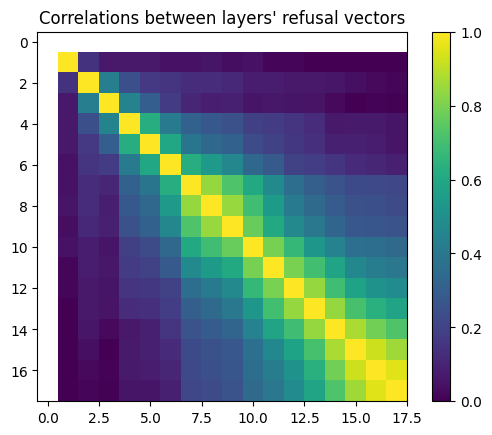

In [8]:
from matplotlib import pyplot as plt
from tqdm import tqdm
from micrlhf.utils.load_sae import get_nev_it_sae_suite, sae_encode_gated
import numpy as np
residiffs = []
last_resids = []
overall_saes = []
all_lengths = []
for i, resid in enumerate(tqdm(sorted(resids, key=lambda x: int(x.tag.rpartition("_")[-1])))):
    resid = resid.value.unwrap("batch", "seq", "embedding")
    indices = jnp.asarray(tokens["attention_mask"].sum(1, keepdims=True))[..., None] - 1
    all_lengths = indices[:, 0, 0].tolist()
    try:
        sae = get_nev_it_sae_suite(i)
        activations_layer = []
        for r, length in zip(resid, indices):
            length = int(length.flatten()[0])
            _, post_relu, _ = sae_encode_gated(sae, r[:length])
            post_relu = np.array(post_relu)
            activation_batch = []
            for seq in range(length):
                vec = post_relu[seq]
                idx = np.nonzero(vec)[0]
                activation_batch.append({int(k): float(vec[k]) for k in idx})
            activations_layer.append(activation_batch)
    except IndexError:
        activations_layer = None
    overall_saes.append(activations_layer)
    last_resid = jnp.take_along_axis(resid, indices, 1)[:, 0]
    last_resid = last_resid.reshape(2, -1, last_resid.shape[-1])
    last_resids.append(last_resid)
    last_resid = last_resid.mean(1)
    residiff = np.array(last_resid[0] - last_resid[1])
    residiff = residiff / np.linalg.norm(residiff)
    residiffs.append(residiff)
matmuls = np.matmul(residiffs, np.transpose(residiffs))
norms = np.linalg.norm(residiffs, axis=-1) + 1e-10
plt.title("Correlations between layers' refusal vectors")
plt.imshow(matmuls / norms[:, None] / norms[None, :], vmin=0, vmax=1)
plt.colorbar()
plt.show()

In [9]:
frequent_features = set()
topk_frequent = 6
for layer, batch in enumerate(overall_saes):
    if batch is None:
        continue
    for sequence in batch:
        for seq_index, seq_item in enumerate(sequence):
            freq_for_token = sorted(seq_item.items(), key=lambda x: x[1], reverse=True)[:topk_frequent]
            for feature, _ in freq_for_token:
                frequent_features.add((layer, feature))

In [10]:
from micrlhf.utils.vector_storage import save_and_upload_vector, download_vector
from micrlhf.utils.load_sae import get_nev_it_sae_suite
from micrlhf.utils.ito import grad_pursuit


sae_k = 8
threshold = 0.2
interesting_features = set()
for layer_sae in range(3, 16):
    dictionary = get_nev_it_sae_suite(layer_sae)["W_dec"]
    dictionary = dictionary / np.linalg.norm(dictionary, axis=1, keepdims=True)
    for layer in range(1, len(residiffs)):
        vector_name = f"gemma-refusal-l{layer}"
        vector = residiffs[layer]
        vector = vector / np.linalg.norm(vector)
        try:
            save_and_upload_vector(vector_name, vector)
        except FileExistsError:
            pass
        weights, recon = grad_pursuit(vector, dictionary, sae_k, pos_only=True)
        w, i = jax.lax.top_k(jnp.abs(weights), sae_k)
        print(f"Layer {layer} -> Layer {layer_sae}: {[(int(a), float(b)) for a, b in zip(i, w)]}")
        for f, u in zip(i, w):
            if u < threshold:
                continue
            interesting_features.add((layer_sae, int(f)))
    print()
all_feats = interesting_features

Layer 1 -> Layer 3: [(18635, 0.17675743997097015), (5787, 0.15255925059318542), (31785, 0.1463126391172409), (29242, 0.1331372708082199), (21766, 0.1092173159122467), (27462, 0.10757730901241302), (27133, 0.09293080121278763), (20770, 0.09026703983545303)]
Layer 2 -> Layer 3: [(27665, 0.1331675946712494), (26813, 0.13294799625873566), (18635, 0.1273411512374878), (16749, 0.11931315809488297), (16328, 0.11060155183076859), (23168, 0.10127710551023483), (22116, 0.08303949981927872), (12334, 0.0823347419500351)]
Layer 3 -> Layer 3: [(27665, 0.42832329869270325), (15052, 0.1459847390651703), (5365, 0.11913321167230606), (21076, 0.10440956801176071), (3946, 0.10437213629484177), (30204, 0.09580910950899124), (30616, 0.09381666779518127), (29365, 0.09313101321458817)]
Layer 4 -> Layer 3: [(27665, 0.2250392735004425), (25245, 0.134083092212677), (17001, 0.10403354465961456), (173, 0.09581781178712845), (1800, 0.0872500017285347), (19812, 0.08270901441574097), (7554, 0.08096931129693985), (102

In [11]:
from collections import defaultdict
# interesting_hists = {k: [] for k in interesting_features}
interesting_hists = defaultdict(list)
for layer, batch in enumerate(overall_saes):
    if batch is None:
        continue
    for batch_idx, sequence in enumerate(batch):
        for seq_index, seq_item in enumerate(sequence):
            for feature, value in seq_item.items():
                # if (layer, feature) in interesting_features:
                interesting_hists[(layer, feature)].append((batch_idx, seq_index, value))

In [12]:
interests = []
for fname, occurences in interesting_hists.items():
    if len([o for o in occurences if o[0] < len(prompts_harmful)]) / len(occurences) > 0.8:
        interests.append((len(occurences), fname))
interests = sorted(interests, reverse=True)[:128]
for layer in range(100):
    x = [i for _, i in interests if i[0] == layer]
    if x:
        display(x)

[(4, 4880), (4, 6207), (4, 3967)]

[(5, 11923), (5, 11811)]

[(6, 24633), (6, 27192), (6, 6180), (6, 3929), (6, 27407), (6, 14929)]

[(7, 12374),
 (7, 27489),
 (7, 17461),
 (7, 18152),
 (7, 10734),
 (7, 13881),
 (7, 29720)]

[(8, 24983),
 (8, 8286),
 (8, 30433),
 (8, 10780),
 (8, 19254),
 (8, 29985),
 (8, 18083),
 (8, 17050),
 (8, 6911),
 (8, 4526)]

[(9, 19981),
 (9, 16576),
 (9, 7160),
 (9, 28982),
 (9, 20153),
 (9, 31079),
 (9, 7088),
 (9, 24761),
 (9, 11754),
 (9, 25006),
 (9, 22469),
 (9, 14006)]

[(10, 3913),
 (10, 19460),
 (10, 31748),
 (10, 28397),
 (10, 19867),
 (10, 8317),
 (10, 6125),
 (10, 1067),
 (10, 12173),
 (10, 938),
 (10, 14780),
 (10, 17579),
 (10, 26322),
 (10, 719)]

[(11, 3454),
 (11, 16031),
 (11, 22528),
 (11, 22314),
 (11, 20767),
 (11, 12668),
 (11, 11581),
 (11, 6066),
 (11, 669),
 (11, 11786),
 (11, 20449),
 (11, 13647),
 (11, 11854),
 (11, 28189),
 (11, 18590),
 (11, 26496)]

[(12, 4786),
 (12, 23446),
 (12, 3747),
 (12, 5809),
 (12, 22728),
 (12, 14894),
 (12, 14785),
 (12, 21306),
 (12, 23828),
 (12, 31339),
 (12, 22458),
 (12, 22631),
 (12, 20429)]

[(13, 3721),
 (13, 11835),
 (13, 27314),
 (13, 21604),
 (13, 10671),
 (13, 13347),
 (13, 1786),
 (13, 2991),
 (13, 20059),
 (13, 21016),
 (13, 19696),
 (13, 8705),
 (13, 21115)]

[(14, 2590),
 (14, 16332),
 (14, 22461),
 (14, 13308),
 (14, 7126),
 (14, 4934),
 (14, 32514),
 (14, 26536),
 (14, 27721),
 (14, 20739),
 (14, 3040),
 (14, 24515),
 (14, 28888),
 (14, 32011),
 (14, 12730),
 (14, 27459)]

[(15, 15081),
 (15, 21913),
 (15, 26548),
 (15, 16915),
 (15, 21149),
 (15, 27030),
 (15, 23966),
 (15, 28559)]

[(16, 15596),
 (16, 2883),
 (16, 25424),
 (16, 4719),
 (16, 21510),
 (16, 8464),
 (16, 12888),
 (16, 19021)]

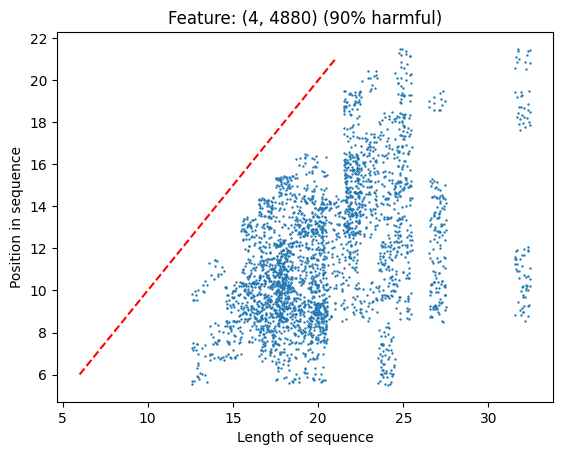

In [13]:
from circuitsvis.tokens import colored_tokens
from matplotlib import pyplot as plt

# feat = (3, 1251)  # always on user, sometimes on the subject of a request
# feat = (3, 31377)  # just "do a" feature
# feat = (3, 28893)  # same here

feat = (4, 4880)  # subject, mostly on harmful; 
# feat = (4, 6207)  # after a harmful word was mentioned; subject after harmful topic word
# feat = (4, 3967)  # design, develop; subject

# feat = (5, 11923)  # hack what? trick into what?
# feat = (5, 11811)  # entire harmful request; activates on model

# feat = (9, 19981)  # violence; subject; drugs + start_of_turn + beggining of response

# unverified:
# feat = (9, 13120)  # organization providing information (sparse, late + early)
# feat = (14, 27459)  # do not (last few tokens only, checkerboard pattern?..)
# feat = (15, 21913)  # person providing something (last few tokens + earlier)
# feat = (8, 8286)  # do something against the law (early)
# feat = (15, 21149)  # thing being talked about (last few tokens only)

hists = interesting_hists[feat]

hists_harmful = [x for x in hists if x[0] < len(prompts_harmful)]
assert len(hists_harmful) > 0
arr_length_pos = np.array([(all_lengths[x[0]], x[1]) for x in hists_harmful])
oversample = 12
plt.title(f"Feature: {feat} ({int(len(hists_harmful) / len(hists) * 100)}% harmful)")
plt.scatter(*(arr_length_pos + np.random.uniform(-0.5, 0.5, size=(oversample,) + arr_length_pos.shape)).reshape(-1, 2).T, s=0.5)
plt.plot(*(([arr_length_pos[:, 1].min(0), arr_length_pos[:, 1].max(0)],) * 2), color="red", linestyle="--")
plt.xlabel("Length of sequence")
plt.ylabel("Position in sequence")
plt.show()
max_acts = sorted(hists, key=lambda x: x[2], reverse=True)
visited_batches = set()
for (batch_idx, seq_index, value) in max_acts:
    if batch_idx in visited_batches:
        continue
    if len(visited_batches) >= 10:
        break
    try:
        tokens = tokenizer.tokenize(prompts_harmful[batch_idx])
    except IndexError:
        tokens = tokenizer.tokenize(prompts_harmless[batch_idx - len(prompts_harmful)])
    visited_batches.add(batch_idx)
    to_splat = np.zeros(len(tokens))
    for (bidx, sidx, val) in hists:
        if bidx == batch_idx:
            to_splat[sidx] = val
    display(colored_tokens(tokens, to_splat))

In [14]:
get_rms = lambda layer, is_mlp: (
            llama.select()
            .at_instances_of(LlamaBlock).pick_nth_selected(layer)
            .at_instances_of(pz.nn.Residual).pick_nth_selected(int(is_mlp))
            .at_instances_of(pz.nn.RMSLayerNorm).pick_nth_selected(0)
            ).at_instances_of(pz.nn.Linear).pick_nth_selected(0).get().weights.value.unwrap("embedding")

In [19]:
from tqdm.auto import trange
rmses_mlp = [get_rms(layer, True) for layer in trange(18)]
rmses_attn = [get_rms(layer, False) for layer in trange(18)]

In [20]:
from micrlhf.llama import LlamaAttention
influences = {}
influences_attn = {}
all_feat_directions = {}

def prop_sae(feat_source, sae_mid, feat_target, rms_source):
    strengths = ((feat_source * rms_source) @ sae_mid["W_enc"] * jax.nn.softplus(sae_mid["s_gate"]) * sae_mid["scaling_factor"]) * (sae_mid["W_dec"] @ (feat_target))
    # dic = sae_mid["W_dec"]
    # dic = dic
    # dic_norm = jnp.linalg.norm(dic, axis=1)
    # strengths = ((dic @ feat_source) * (dic @ feat_target)) / (dic_norm ** 2)
    return strengths

n_top = 8
strength_thresh = 1e-3
all_feats = list(interesting_features)
for i, (layer_source, feature_source) in enumerate(tqdm(all_feats)):
    for j, (layer_target, feature_target) in enumerate(all_feats):
        if layer_target <= layer_source:
            continue
        feat_source = get_nev_it_sae_suite(layer_source)["W_dec"][feature_source]
        target_sae = get_nev_it_sae_suite(layer_target)
        feat_target = (target_sae["W_enc"] * jax.nn.softplus(target_sae["s_gate"]) * target_sae["scaling_factor"]).T[feature_target]
        # feat_target = target_sae["W_dec"][feature_target]
        # feat_source = feat_source / np.linalg.norm(feat_source)
        # feat_target = feat_target / np.linalg.norm(feat_target)

        edge_key = ((layer_source, feature_source), (layer_target, feature_target))
        all_feat_directions[edge_key] = (np.array(feat_source), np.array(feat_target))
        influencers = []
        for layer_mid in range(layer_source , layer_target):
            try:
                sae_mid = get_nev_it_sae_suite(layer_mid, label="transcoder")
            except IndexError:
                continue
            strengths = prop_sae(feat_source, sae_mid, feat_target, rmses_mlp[layer_mid])
            top_effects, top_feats = jax.lax.top_k(jnp.abs(strengths), n_top)
            for f in top_feats:
                influencers.append((float(strengths[f]), layer_mid, int(f)))
        # influencers.sort(key=lambda x: abs(x[0]))
        # display(influencers)
        influencers = [(s, l, f) for s, l, f in influencers if abs(s) > strength_thresh]  # vibes
        influences[edge_key] = influencers
        
        influencers_attn = []
        for layer_mid in range(layer_source, layer_target):
            try:
                sae_mid = get_nev_it_sae_suite(layer_mid, label="attn_out")
            except IndexError:
                continue
            attn_layer = llama.select().at_instances_of(LlamaAttention).get_sequence()[layer_mid]
            v_linear = attn_layer.input_to_value.select().at_instances_of(pz.nn.Linear).get_sequence()[0].weights.value
            o_linear = attn_layer.attn_value_to_output.select().at_instances_of(pz.nn.Linear).get_sequence()[0].weights.value
            fs = jnp.einsum("a,abc,rbco->o", feat_source, v_linear.unwrap("embedding", "kv_heads", "projection"), o_linear.unwrap("q_rep", "kv_heads", "projection", "embedding"))
            strengths = prop_sae(fs, sae_mid, feat_target, rmses_attn[layer_mid])
            top_effects, top_feats = jax.lax.top_k(jnp.abs(strengths), n_top)
            for f in top_feats:
                influencers_attn.append((float(strengths[f]), layer_mid, int(f)))
        # influencers_attn.sort(key=lambda x: abs(x[0]))
        influencers_attn = [(s, l, f) for s, l, f in influencers_attn if abs(s) > strength_thresh]
        influences_attn[edge_key] = influencers_attn

  0%|          | 0/47 [00:00<?, ?it/s]

100%|██████████| 47/47 [06:51<00:00,  8.76s/it]


In [21]:
interesting_attn_outs = set()
for key, influencers in influences_attn.items():
    for _, layer, feature in influencers:
        interesting_attn_outs.add((layer, feature))

In [23]:
from tqdm.auto import tqdm
import requests
import numpy as np
import textwrap
import os
import json

def norm(x):
    x = np.array(x)
    x = x / max(1e-3, x.max())
    return x

feat_dir = "data/feature_explanations"
os.makedirs(feat_dir, exist_ok=True)
feat_explanations = {}
max_len = 72
linebreak = 12
max_tries = 2
for t, l, f in tqdm(set(("R", l, f) for l, f in interesting_features) | set(("A", l, f) for l, f in interesting_attn_outs)):
    data = {}
    tries = 0
    while not data or set(data.keys()) == {"error"}:
        if tries > max_tries or l < 6:
            break
        filename = f"{feat_dir}/explanation_{t}_{l}_{f}.json"
        if os.path.exists(filename) and tries == 0:
            with open(filename, 'r') as file:
                data = json.load(file)
        else:
            response = requests.get(f"https://datasets-server.huggingface.co/rows?dataset=kisate-team%2Fgemma-2b-suite-explanations&config=l{l}{'' if t == 'R' else '_attn_out' if t == 'A' else 1/0}&split=train&offset={f}&length=1")
            data = response.json()
            with open(filename, 'w') as file:
                json.dump(data, file)
        tries += 1
    if tries > max_tries or l < 6 or not data["rows"]:
        feat_explanations[f"{t}{l}.{f}"] = f"{t}{l}.{f}"
        print("Skip", (t, l, f))
        continue
    
    feat_info = data["rows"][0]["row"]
    criterion = norm(feat_info["scale_tuning"]["selfsims"][-2]) * 0.4 - 0.6 * norm(feat_info["scale_tuning"]["entropy"])
    scale = feat_info["scale_tuning"]["scales"][np.argmax(criterion[10:]) + 10]
    index = np.searchsorted(feat_info["generations"]["scales"], scale)
    texts = feat_info["generations"]["texts"]
    # display((l, f, scale, texts[index], texts))
    print((t, l, f, scale, repr(texts[index])))
    unprocessed = texts[index]
    processed = unprocessed.partition("<eos>")[0].partition('"')[0].strip()
    if len(processed) > max_len:
        processed = processed[:max_len] + "..."
    processed = f"{t}{l}.{f}: {processed}"
    feat_explanations[f"{t}{l}.{f}"] = textwrap.fill(processed, width=linebreak)

  0%|          | 0/10055 [00:00<?, ?it/s]

('A', 8, 11043, 31.746031746031743, '\'in the place of; at the point of; in the position of". It is\'')
Skip ('A', 5, 32437)
('A', 9, 14126, 177.77777777777777, '\'a relationship or connection between two or more people, things, or things." \\n\\n\'')
('A', 9, 1065, 76.19047619047619, '\'something" or "a thing". It is a generic definiton that refers to something\'')
('A', 11, 1663, 174.60317460317458, '\'something that is a specific type of something". It can also mean "a person,\'')
('A', 6, 22230, 168.25396825396825, '\'something that is liked or favored". It is often used to refer to something that is\'')
('A', 7, 25047, 200.0, '\'a matter or issue to be considered". It is often used to refer to a subject\'')
('A', 7, 22832, 200.0, '\'remaining" or "surplus". It is often used in the phrase "a slice\'')
Skip ('A', 5, 27189)
('A', 11, 9247, 31.746031746031743, '\'to write or compose a song, poem, or other piece of literature".<eos>For\'')
('A', 6, 32029, 31.746031746031743, '\'an asse

  0%|          | 0/47 [00:00<?, ?it/s]

Included: 40 Total: 47


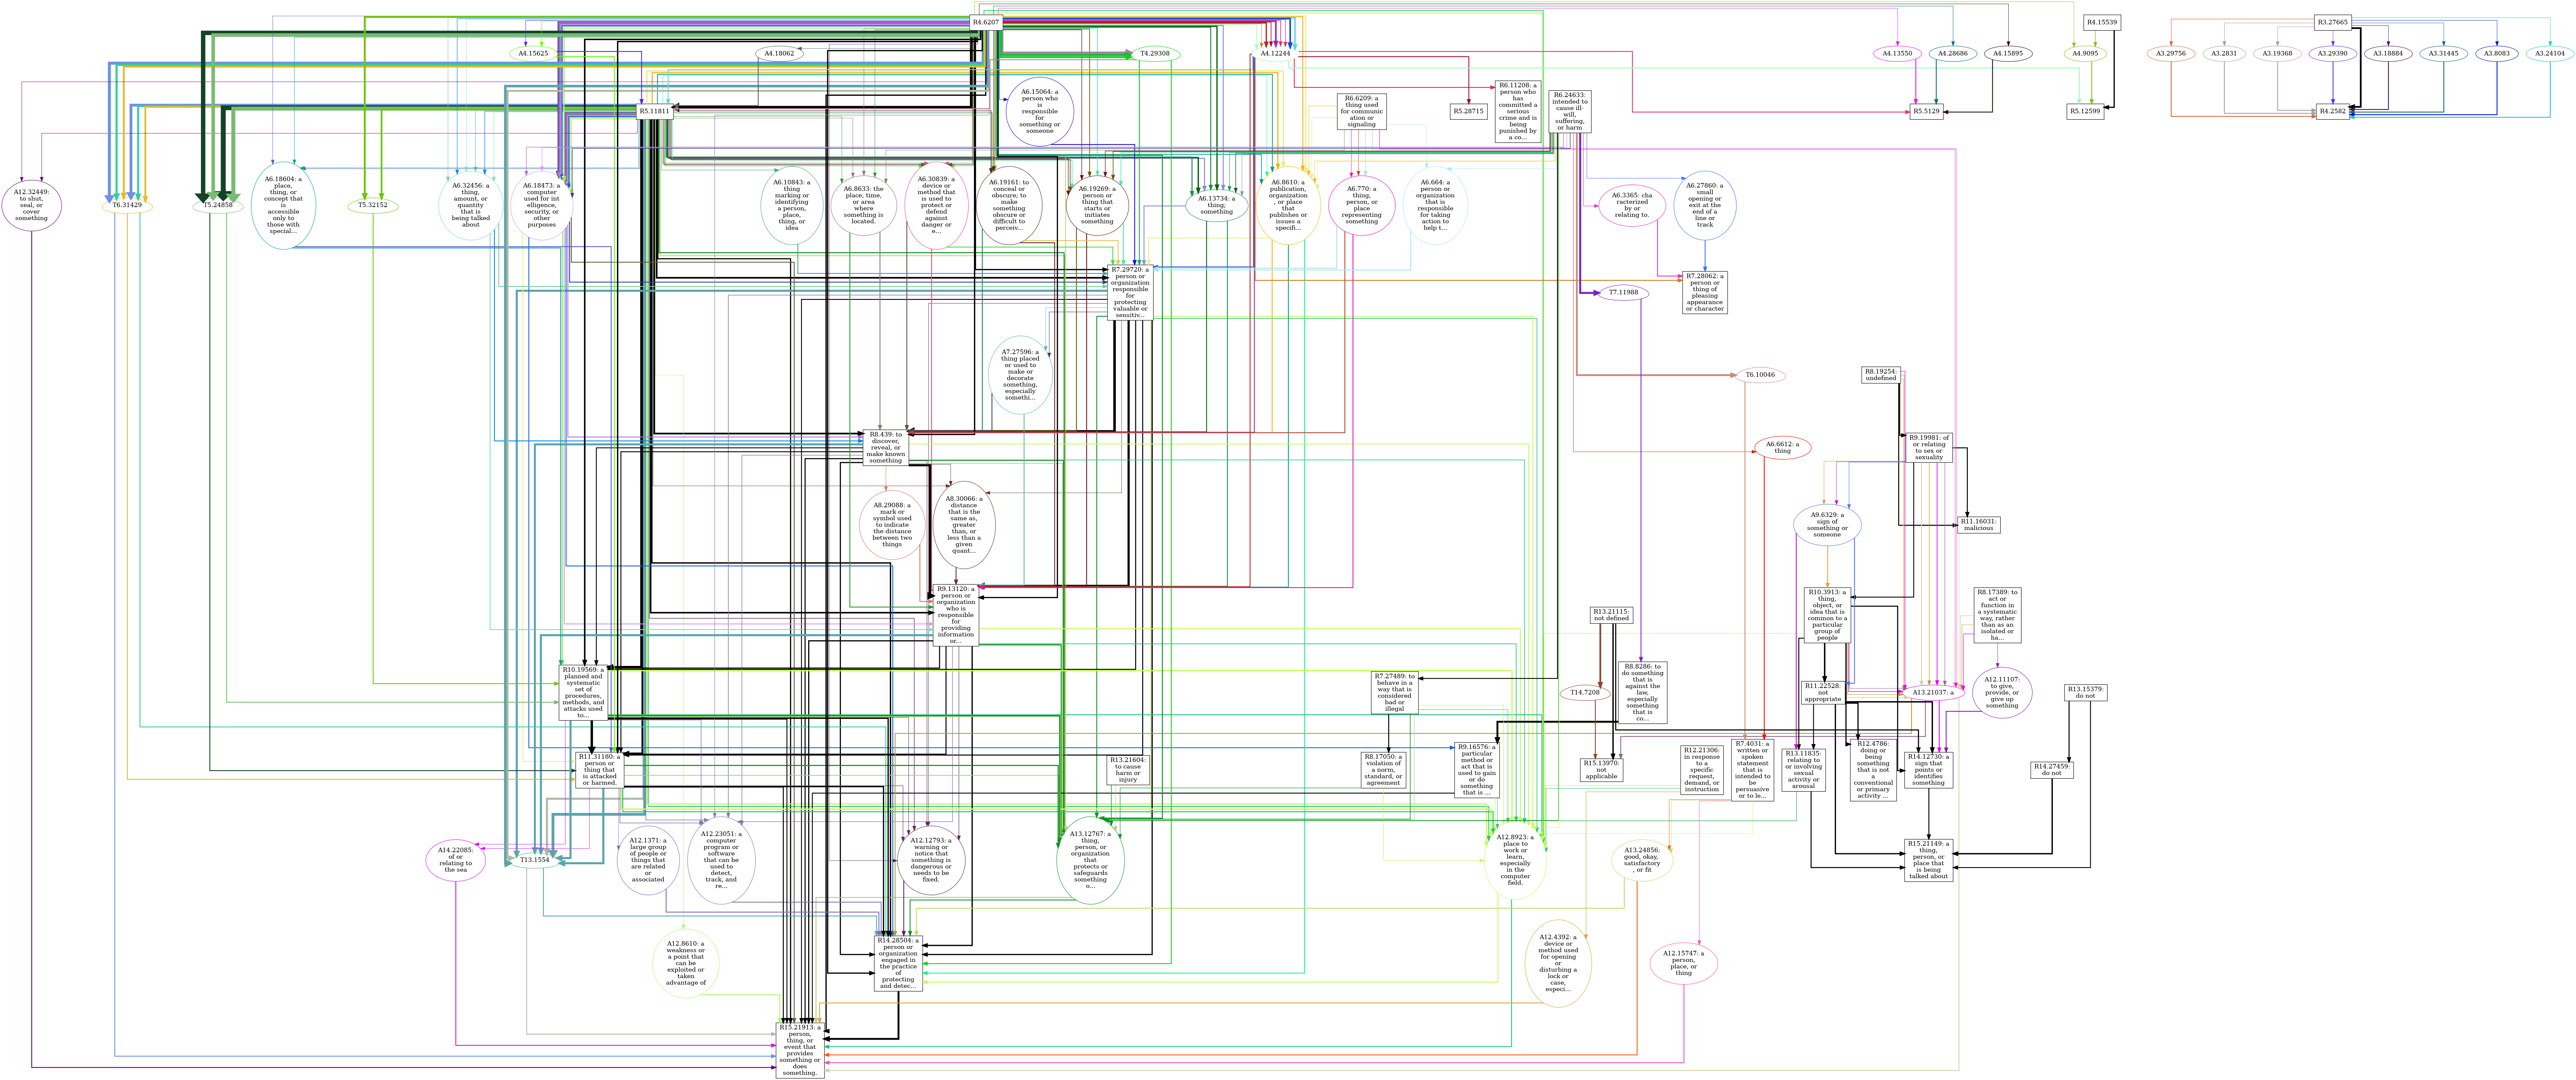

In [24]:
from IPython.display import Image as IImage
from tqdm.auto import tqdm
import graphviz
import random

graph = graphviz.Digraph(graph_attr={"overlap": "scale", "splines": "ortho", "engine": "sfdp"})
edges_out = set()
direct_thresh = 0.3
letter_thresholds = {"T": 0.1, "A": 0.02}
included_nodes = set()
s_scales = {"T": 0.05, "A": 0.05}
penwidth_edge = 2
penwidth_direct = 2
direct_scale = 0.3
for i, (layer_source, feature_source) in enumerate(tqdm(all_feats)):
    for j, (layer_target, feature_target) in enumerate(all_feats):
        if layer_source == layer_target or layer_source > layer_target:
            continue
        name_source = f"R{layer_source}.{feature_source}"
        name_target = f"R{layer_target}.{feature_target}"
        
        edge_key = ((layer_source, feature_source), (layer_target, feature_target))
        a, b = all_feat_directions.get(edge_key, (np.zeros(0), np.zeros(0)))
        draw_direct_edge = a @ b > direct_thresh
        if draw_direct_edge:
            graph.edge(name_source, name_target, color="black", penwidth=f"{penwidth_direct * abs(a @ b) / direct_scale:.4f}")
        influencers = influences.get(edge_key, [])
        influencers_attn = influences_attn.get(edge_key, [])
        
        influencers = [("T", s, l, f) for s, l, f in influencers] + [("A", s, l, f) for s, l, f in influencers_attn]
        influencers = [(t, s, l, f) for t, s, l, f in influencers if abs(s) > letter_thresholds[t]]
        has_edge = draw_direct_edge or influencers
        if has_edge:
            graph.node(name_source, label=feat_explanations[name_source], shape="box")
            graph.node(name_target, label=feat_explanations[name_target], shape="box")
            included_nodes.add(name_source)
            included_nodes.add(name_target)
        
        for letter, s, l, f in influencers:
            edge = f"{letter}{l}.{f}"
            edge_name = feat_explanations.get(edge, edge)
            edge_out = edge, name_target
            gen = random.Random("->".join(edge_out))
            r, g, b = gen.randint(0, 255), gen.randint(0, 255), gen.randint(0, 255)
            color = f"#{r:02X}{g:02X}{b:02X}"
            graph.node(edge, label=edge_name, shape=dict(A="ellipse", T="egg")[letter], color=color)
            graph.edge(name_source, edge, color=color, penwidth=f"{penwidth_edge * abs(s) / s_scales[letter]:.4f}")
            if edge_out in edges_out:
                continue
            edges_out.add(edge_out)
            graph.edge(*edge_out, color=color, penwidth=str(penwidth_edge))
graph.render("data/refusal-gemma-2b", format="png", cleanup=True)
print("Included:", len(included_nodes), "Total:", len(all_feats))
IImage("data/refusal-gemma-2b.png")